In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Data

In [ ]:
coins = ['bitcoin','ethereum','ripple','binancecoin','solana','dogecoin','staked-ether','cardano','tron','avalanche-2','chainlink']
data = pd.read_csv('./processed_data/data1.csv')
for col in data.columns:
    if col != 'timestamp':
        data[f'{col}_squared_log_returns'] = np.log(data[col] / data[col].shift(1)) ** 2
        data[f'{col}_log_volatility'] = np.log(data[col] / data[col].shift(1)).rolling(5).std()
        
        # Calculate market volatility
data['market_squared_log_returns'] = data[[f'{coin}_squared_log_returns' for coin in coins]].mean(axis=1)
data['market_log_volatility'] = data[[f'{coin}_log_volatility' for coin in coins]].mean(axis=1)
data.dropna(inplace=True)
print(data.head())

# Dataset

In [12]:
class VolatilityDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [54]:
coin = 'bitcoin'
features = [data[f'{coin}_log_volatility'].values, data[f'{coin}_squared_log_returns'].values, data['market_log_volatility'].values, data['market_squared_log_returns'].values]
target = [data[f'{coin}_log_volatility'].values]
features = np.array(features).T
target = np.array(target).T

# Training Data

In [59]:
# Split data into training and testing sets
train_size = int(len(features) * 0.8)  # Use 80% for training, 20% for testing
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = VolatilityDataset(X_train_tensor, y_train_tensor)
test_dataset = VolatilityDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_size = X_train.shape[1]



4


# LSTM Neural Network

In [60]:
import torch.nn as nn
class VolatilityPredictor(nn.Module):
    def __init__(self, input_size):
        super(VolatilityPredictor, self).__init__()
        self.LSTM = nn.LSTM(input_size, 64, batch_first=True)
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        x,_ = self.LSTM(x)
        x = self.seq(x)
        return x

In [ ]:
model = VolatilityPredictor(input_size)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()  # Remove extra dimension
        # Use MSE Loss for Regression
        loss = loss_f(outputs,target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

# Evaluation

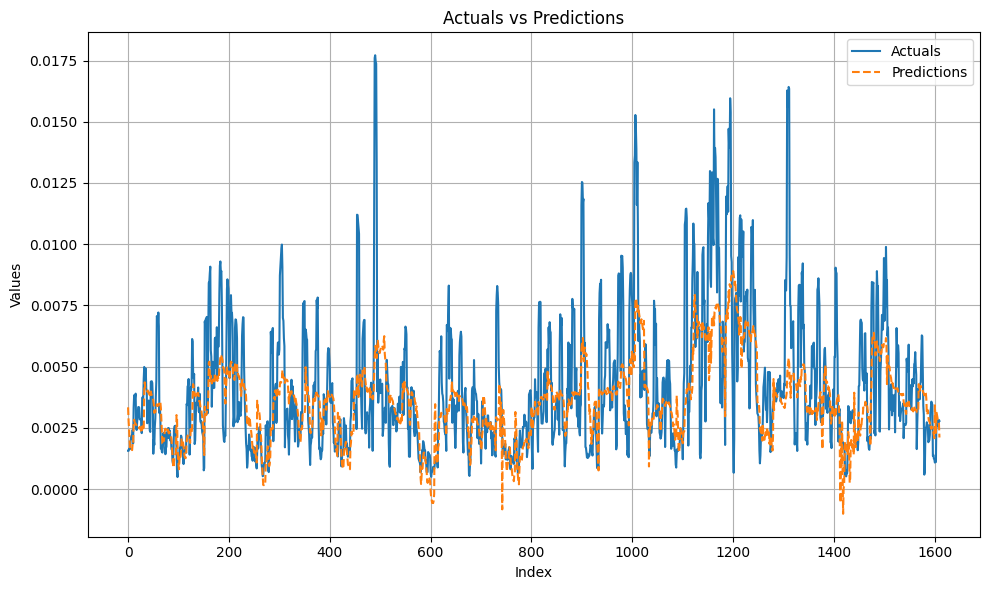

In [69]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    predictions = []
    actuals = []
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions.append(outputs.numpy())
        actuals.append(targets.numpy())

# Flatten lists and compute metrics
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals).T[0]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)
results = pd.DataFrame({
    'actual': actuals,
    'prediction': predictions
})
actuals = results['actual']
predictions = results['prediction']
index = results.index

plt.figure(figsize=(10, 6))
plt.plot(index, actuals, label='Actuals', linestyle='-')
plt.plot(index, predictions, label='Predictions', linestyle='--')

plt.title('Actuals vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()